# Prohet

In [1]:
rm(list = ls())
options(warn = -1)

In [2]:
suppressMessages(library(prophet))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))

In [3]:
folder <- getwd()
train <- read.csv(file.path(dirname(folder), "data/training.csv"))

In [4]:
# Data preparation
y_train <- train[, c(1,2)]
colnames(y_train) <- c("ds", "y")

# Add regressors - y's lags
max_lag <- 30

for (i in 1:max_lag) {
  name_col <- paste("lag_", i, sep = "")
  y_train <- y_train %>%
    mutate(!!name_col := lag(y, n = i))
}

# Add weather covariates
prophet_train <- cbind(y_train, train[, -c(1,2)])
prophet_train <- na.omit(prophet_train)

In [5]:
## CrossValidation to tune change_point_prior_scale, seasonality_prior_scale

#cutoffs <- as.Date(c('2020-05-24', '2020-09-25', '2021-01-27', '2021-05-30', '2021-09-30'))
#changepoint_prior_scale= c(0.001, 0.01, 0.1, 0.5)
#seasonality_prior_scale= c(0.01, 0.1, 1.0, 10, 25,50)

#rmses<-matrix(NA,4,6)
#colnames(rmses)<-c(paste0( "season_", seasonality_prior_scale))
#rownames(rmses)<-c(paste0( "change_", changepoint_prior_scale))

#for(cp in changepoint_prior_scale){
#  for(ss in seasonality_prior_scale){
#     p0 <- prophet(seasonality.prior.scale = ss, changepoint.prior.scale = cp, daily.seasonality = F)
#       for (regressor in colnames(prophet_train[, -c(1, 2)])){
#            p0 <- add_regressor(p0, regressor)            
#            }
#    prophet_cv <- fit.prophet(p0, prophet_train)
#    
#    # Best 1 step ahead predictions
#    cv <- cross_validation(prophet_cv, horizon=230, units="days", cutoffs = cutoffs)
#    rmse_cv <- performance_metrics(cv, metrics = "rmse")  
    
#    rmses[paste0( "change_", cp), paste0( "season_", ss)]<-mean(rmse_cv$rmse)
#      }
#    }
#rmses

In [6]:
# Best Parameters and Model Estimation
# change_point_prior_scale = 0.01, seasonality_prior_scale = 15

p0 <- prophet(seasonality.prior.scale = 15, changepoint.prior.scale = 0.01, daily.seasonality = F)
for (regressor in colnames(prophet_train[, -c(1,2)])){
    p0 <- add_regressor(p0, regressor)
    }

prophet_model <- fit.prophet(p0, prophet_train)

# prophet_model

In [7]:
# Predictions
test <- read.csv(file.path(dirname(folder), "data/testing.csv"))
exp_test <- rbind(tail(train, 30), test)

# Prepare data for prediction
y_test <- exp_test[, c(1,2)]
colnames(y_test) <- c("ds", "y")

# Add regressors - y's lags
max_lag <- 30

for (i in 1:max_lag) {
  name_col <- paste("lag_", i, sep = "")
  y_test <- y_test %>%
    mutate(!!name_col := lag(y, n = i))
}

# Add weather covariates
prophet_test <- cbind(y_test, exp_test[, -c(1,2)])
prophet_test <- na.omit(prophet_test)

df_predictions <- data.frame(ds = prophet_test$ds,
                             pred=rep(NA, nrow(prophet_test)))

prophet_pred <- predict(prophet_model, prophet_test[,-2])
prophet_pred <- as.data.frame(cbind(prophet_pred$yhat, prophet_test$y, prophet_test$ds))
colnames(prophet_pred) <- c("Predicted", "Observed","date")
prophet_pred$date <- as.Date(prophet_pred$date, format = "%Y-%m-%d")
prophet_pred$Predicted <- as.numeric(prophet_pred$Predicted)
prophet_pred$Observed <- as.numeric(prophet_pred$Observed)

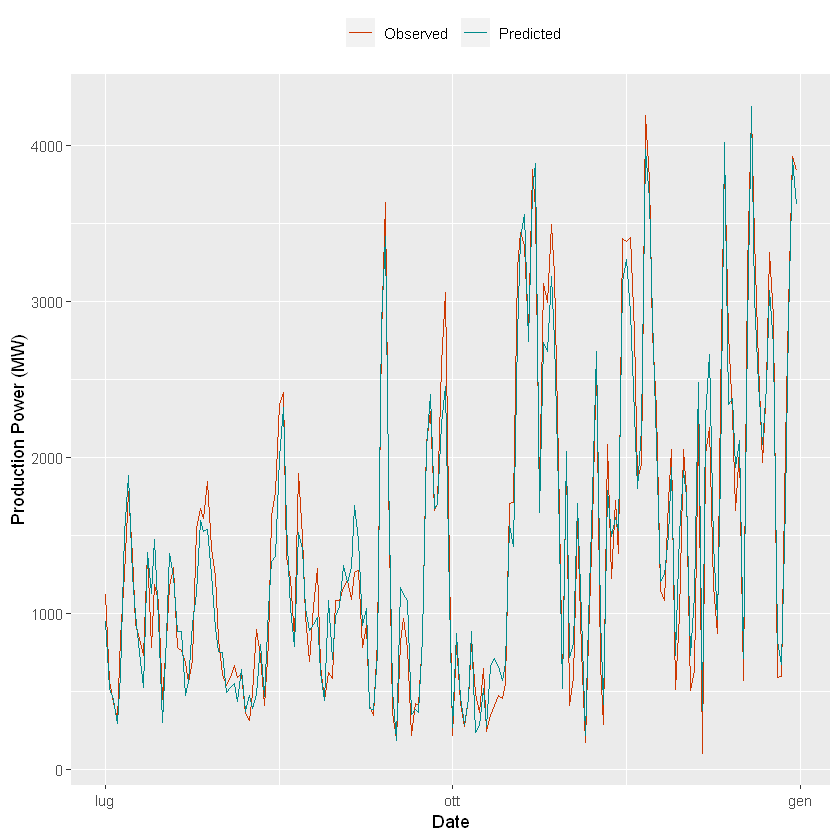

In [8]:
ggplot(prophet_pred, aes(x=date,y=Observed))+
  geom_line(aes(x=date,y=Observed, color="Observed"))+
  geom_line(aes(x=date, y=Predicted, color="Predicted"))+
  labs(color="", x="Date", y="Production Power (MW)")+
  scale_colour_manual(values=c("Observed"="orangered3", "Predicted"="cyan4"))+
  theme(legend.position = "top")

In [9]:
# Save predictions
write.csv(prophet_pred, file=file.path(folder, "predictions/prophet_predictions.csv"), row.names = FALSE)